## <center>Steam Game Owner Number Prediction<center>
This is a project for steam game owner number prediction. Owner number is an indicator of the game selling units, therefore this model should be helpful for game developer and publisher.

## Outline
### *1. EDA:*
>1) [Check dataset](#CheckData)<br> 
2) [Take a look at target feature (owner number)](#Target)<br> 
3) [Analyze categorical features (split and frequency)](#Categories)<br> 
4) [Analyze numerical features (correlation)](#Numerical)<br> 
5) [Generate new features](#NewFeature)<br> 
### *2. Model development:*
>1) [Prepare training, validation, test set](#PrepareData)<br> 
2) [Train model (XGB classification)](#TrainModel)<br> 
### *3. Performance Analysis:*
>1) [Performance check](#CheckPerformance)<br> 
2) [Error analysis](#ErrorAnalysis)<br> 
3) [Get development advice from feature importance](#FeatureImp)<br> 

*****************************************************************

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier
import pickle
import time
import wordcloud
import seaborn

%matplotlib inline

## *1. EDA*

### <a id="CheckData"></a> 1) Check Dataset

In [2]:
### Check Columns ####
### Total number of games ###
df = pd.read_csv("../data/steam.csv")
print("The dataset is provided by Nik Davis and can be found https://www.kaggle.com/nikdavis/steam-store-games")
print("Dateset includes {} different games".format(df.shape[0]))
print("There are {} columns in  data".format(len(df.columns)))
print("Among them, some features can be got before the game releasing, which can be used as our input features")
print("Such as :" + ", ".join(df.columns[1:12]) + ", " +  df.columns[-1])
print("Some of them can only be got after the game releasing, which are the targets of our model")
print("Such as :" + ", ".join(df.columns[14:17]))
print("Some of them can be got at both time using pre-release testing, but we need to do certain conversion")
print("Such as :" + ", ".join(df.columns[12:14]))

The dataset is provided by Nik Davis and can be found https://www.kaggle.com/nikdavis/steam-store-games
Dateset includes 27075 different games
There are 18 columns in  data
Among them, some features can be got before the game releasing, which can be used as our input features
Such as :name, release_date, english, developer, publisher, platforms, required_age, categories, genres, steamspy_tags, achievements, price
Some of them can only be got after the game releasing, which are the targets of our model
Such as :average_playtime, median_playtime, owners
Some of them can be got at both time using pre-release testing, but we need to do certain conversion
Such as :positive_ratings, negative_ratings


In [3]:
#### Check General Information ####
df.describe()
#### Check None ####
print("None check:\n{}".format(",".join([df.isnull().columns[idx] + ":" + str(i) for idx, i in enumerate(df.isnull().sum())])))

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,2.707500e+04,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000
mean,5.962035e+05,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193
std,2.508942e+05,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,4.012300e+05,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.690000
50%,5.990700e+05,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,3.990000
75%,7.987600e+05,1.000000,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,7.190000
max,1.069460e+06,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,421.990000


None check:
appid:0,name:0,release_date:0,english:0,developer:0,publisher:0,platforms:0,required_age:0,categories:0,genres:0,steamspy_tags:0,achievements:0,positive_ratings:0,negative_ratings:0,average_playtime:0,median_playtime:0,owners:0,price:0


In [4]:
#### Check Repeate Game Names ####
name_list = {s:0 for s in set(df["name"])}
for i in df["name"]:
    name_list[i] += 1
name_repeate = []
for key,value in name_list.items():
    if value != 1:
        name_repeate.append(key)
        
print("There are " + str(len(name_repeate)) + " game names are repetitive")
print("They are: " +  ", ".join(name_repeate))
### One example
df[df["name"] == "New York Bus Simulator"]

There are 41 game names are repetitive
They are: City Builder, Escape Room, Exodus, 2048, New York Bus Simulator, Solitaire, Zombie Apocalypse, Ashes, Rumpus, Experience, Invasion, Evolution, Mars 2030, Escape, Castles, Colony, Chaos Theory, The Great Escape, Bounce, Scorch, Taxi, The Mine, Hide and Seek, RUSH, Dodge, Cortex, Ultimate Arena, The Tower, Killing Time, Slice&Dice, Santa's Workshop, Nightmare Simulator, Alone, Dark Matter, Luna, Fireflies, Alter Ego, Beyond the Wall, Surge, Space Maze, Mystical


,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
2729,283580,New York Bus Simulator,2014-08-06,1,TML-Studios,Aerosoft GmbH,windows,0,Single-player,Simulation,Simulation;Masterpiece;Driving,0,29,35,0,0,0-20000,8.99
8227,446480,New York Bus Simulator,2016-03-04,1,Little Freedom Factory,United Independent Entertainment GmbH,windows,0,Single-player,Simulation,Simulation,0,7,42,0,0,0-20000,3.99


### <a id="Target"></a> 2) Target feature: owner number
Here, since owners is categorical feature , we tried to use the median(also average here) to convert it into numerical features.

In [5]:
def getMedian(x):
    '''
    Get median of range 
    '''
    x_list = [ float(x) for x in x.split("-")]
    x_median = np.median(x_list)
    return x_median

In [6]:
df_prepare = df.copy()
df_prepare["owners_median"] = df["owners"].apply(lambda x: getMedian(x))

In [7]:
df_owner_infor = { df_tmp[0]: len(df_tmp[1]) for df_tmp in df_prepare.groupby("owners")}
df_owner_infor = { x:y for x,y in sorted(df_owner_infor.items(), key = lambda x: getMedian(x[0]))}

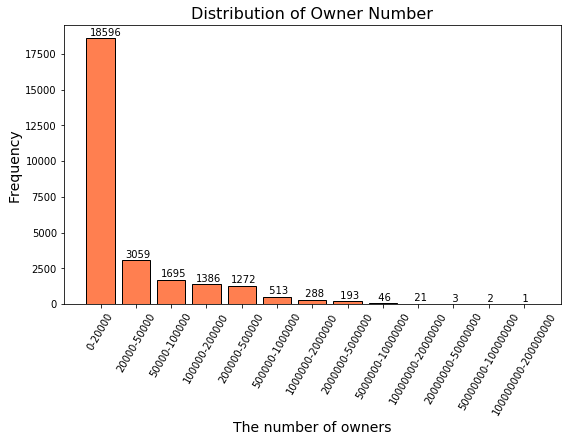

In [8]:
### Distribution ###
fig = plt.figure(figsize=[8,6])
ax = plt.gca()
plt.bar(df_owner_infor.keys(), df_owner_infor.values(), edgecolor="black", color="coral")
for idx, key in enumerate(df_owner_infor.keys()):
    ax.annotate("{:>4s}".format(str(df_owner_infor[key])), (idx-0.3, df_owner_infor[key] + 200), fontsize=10)
plt.xticks(rotation="60", fontsize=10)
plt.tight_layout(pad=2)
plt.xlabel("The number of owners", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Distribution of Owner Number", size=16);
#plt.savefig("Owners_distribution.jpg", dpi=300);

It is clearly that the owners of most games are in 0-20000 range, and some games have very high number owners, which are larger than 50 million. This results indicates that our dataset is **unbalanced** and should be processed carefully in the model development. <br>
Since there are only 27 games have owners larger than 10 million, we combined these games together and form the "lager than 10 million" class in model devlopment. 

In [9]:
### Examples: Games with high onwers ###
df_prepare[df_prepare["owners"] == "100000000-200000000"]

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,owners_median
22,570,Dota 2,2013-07-09,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,Free to Play;MOBA;Strategy,0,863507,142079,23944,801,100000000-200000000,0.0,150000000.0


### <a id="Categories"></a> 3) Categorical features

There are many categorical features. Let's check if there is any specific trend in categorical features for successful games

In [10]:
def getTopN(infile, variable, sort_value="owners_median", TopN=5):
    '''
    Get data grouped by certain features and return the TopN results ranking by owners_median
    
    '''
    infile_tmp = infile.groupby(variable).agg({"owners_median":np.mean, "positive_ratings":np.mean,"average_playtime": np.mean, "median_playtime": np.mean})
    
    return infile_tmp.sort_values(sort_value, ascending = False)[0:TopN]

In [11]:
def getDict(infile, variable):
    '''
    Get data grouped by certain features and return the dictionary
    
    '''
    infile_tmp = infile.groupby(variable).agg({"owners_median":np.mean, "positive_ratings":np.mean,"average_playtime": np.mean, "median_playtime": np.mean})
    
    return infile_tmp.to_dict()

In [12]:
def drawWordCloud(freq_dict):
    '''
    Draw wordcloud for categorical features based on freq_dict, freq_dict can be frequency or other variable numbers
    '''
    wc = wordcloud.WordCloud(background_color="white", max_font_size=100, max_words=100, random_state=0).generate_from_frequencies(freq_dict)
    plt.figure(figsize=[8,6])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off");


#### a. categories features with subclass

For platform, categories, genres, steamspy_tags, each game has multiple types. To make the analysis easier, I first **split** them and get the vocabulary of them, then changed them into **one-hot features**, which can be used in future model development.

In [13]:
def getVocab(data, variable):
    '''
    Get vocabulary for certain feature(variable)
    '''
    vocab = {}
    for line in data[variable].tolist():
        if ";" in line:
            line = line.split(";")
        else:
            line = [line]
        for v in line:
            if v not in vocab:
                vocab[v] = 1
            else:
                vocab[v] += 1
    
    vocab = {x:y for x, y in sorted(vocab.items(), key = lambda x: x[1], reverse = True)}
    
    return vocab 

In [14]:
def splitCateg(data, variable, vocab):
    '''
    Split feature with its vocabulary and change it into onehot, and added split feature columns into initial data
    data: initial data
    variable: feature name
    vocab: its vocabulary
    '''
    v_split = {key:[] for key in vocab.keys()}
    for v in data[variable]:
        if ";" in v:
            v = v.split(";")
        else:
            v = [v]
        for key in v_split.keys():
            if key in v:
                v_split[key].append(1)
            else:
                v_split[key].append(0)
    
    v_data = pd.DataFrame(v_split)
    
    data_add = pd.merge(data, v_data , on = data.index)
    data_add.drop("key_0", axis = 1, inplace = True)
    
    return data_add

#### Platform: inlcudes Linux, Windows, and Mac

In [15]:
#### Add split onehot fetaures ####
platform_vocab= getVocab(df_prepare, "platforms")
df_prepare = splitCateg(df_prepare, "platforms", platform_vocab)
df_prepare.shape

(27075, 22)

#### categories

In [16]:
### initial data, show the top 10 categories
getTopN(df_prepare,["categories"])

,owners_median,positive_ratings,average_playtime,median_playtime
categories,,,,
Multi-player;Co-op;Steam Trading Cards;Steam Workshop;SteamVR Collectibles;In-App Purchases;Valve Anti-Cheat enabled,150000000.0,863507.0,23944.0,801.0
Multi-player;Steam Achievements;Full controller support;Steam Trading Cards;Steam Workshop;In-App Purchases;Valve Anti-Cheat enabled;Stats,75000000.0,2644404.0,22494.0,6502.0
Multi-player;Online Multi-Player;Stats,37575000.0,248303.5,11502.5,6250.5
Single-player;Online Multi-Player;Online Co-op;Steam Achievements;Steam Trading Cards;VR Support;Steam Workshop;In-App Purchases;Steam Cloud;Valve Anti-Cheat enabled;Stats;Includes level editor,35000000.0,292574.0,3248.0,413.0
Multi-player;Cross-Platform Multiplayer;Steam Achievements;Steam Trading Cards;Captions available;Steam Workshop;In-App Purchases;Partial Controller Support;Valve Anti-Cheat enabled;Stats;Includes level editor;Commentary available,35000000.0,515879.0,8495.0,623.0


There are 29 categories


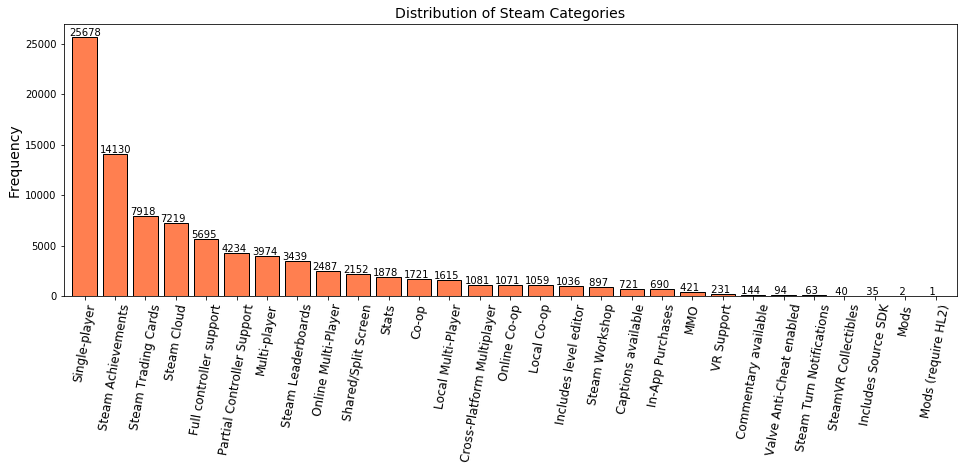

In [17]:
#### Get categories vocabulary ####
cat_vocab = getVocab(df_prepare, "categories")
print("There are " + str(len(cat_vocab)) + " categories")
fig = plt.figure(figsize=[16,5])
ax = plt.gca()
plt.bar(cat_vocab.keys(),cat_vocab.values(), edgecolor="black", color="coral")
for idx, key in enumerate(cat_vocab.keys()):
    ax.annotate("{:>4s}".format(str(cat_vocab[key])), (idx-0.5, cat_vocab[key] + 100), fontsize=10)
plt.xticks(rotation="80", fontsize=12)
plt.margins(x=0.01)
#plt.xlabel("Different Categories", size=14)
plt.ylabel("Frequency", size=14)
plt.title("Distribution of Steam Categories", size=14);

In [18]:
#### Add split categories features ####
df_prepare = splitCateg(df_prepare, "categories", cat_vocab)

#### Genres

In [19]:
#### Add split genres features ####
genres_vocab = getVocab(df_prepare, "genres")
print("There are " + str(len(genres_vocab)) + " genres_vocab")
df_prepare = splitCateg(df_prepare, "genres", genres_vocab)

There are 29 genres_vocab


#### Steam tags

In [20]:
#### Get genres vocabulary ####
steamspy_vocab = getVocab(df_prepare, "steamspy_tags")
print("There are " + str(len(steamspy_vocab)) + " steamspy_tags")

There are 339 steamspy_tags


In [21]:
#### Add split genres features ####
df_prepare = splitCateg(df_prepare, "steamspy_tags", steamspy_vocab)
df_prepare.shape

(27075, 419)

#### b. Check Game Type Effect on Successful Games

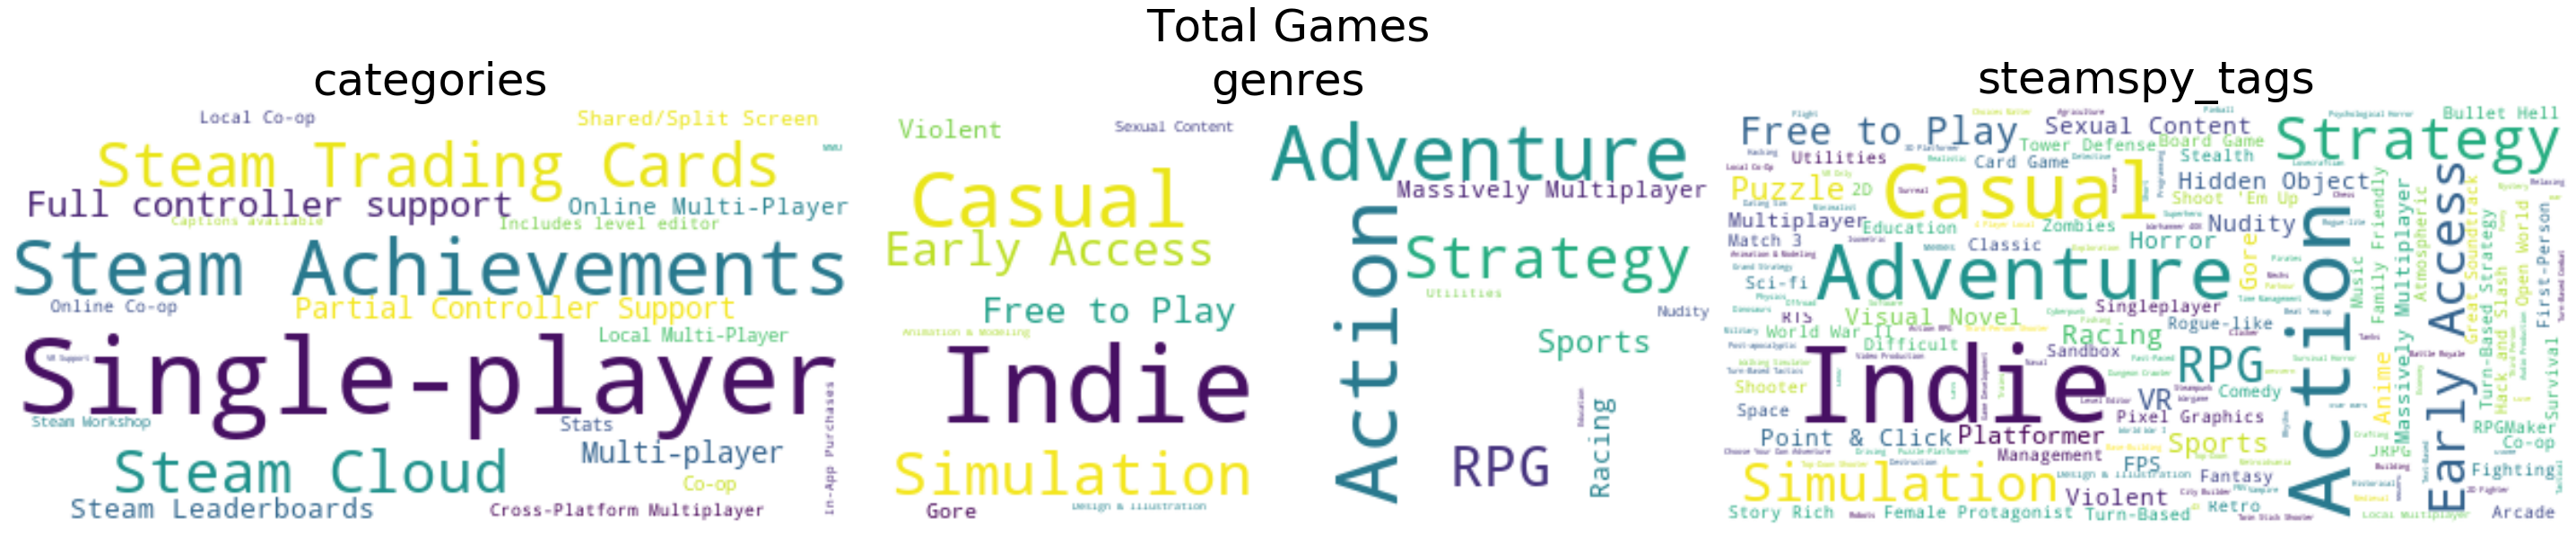

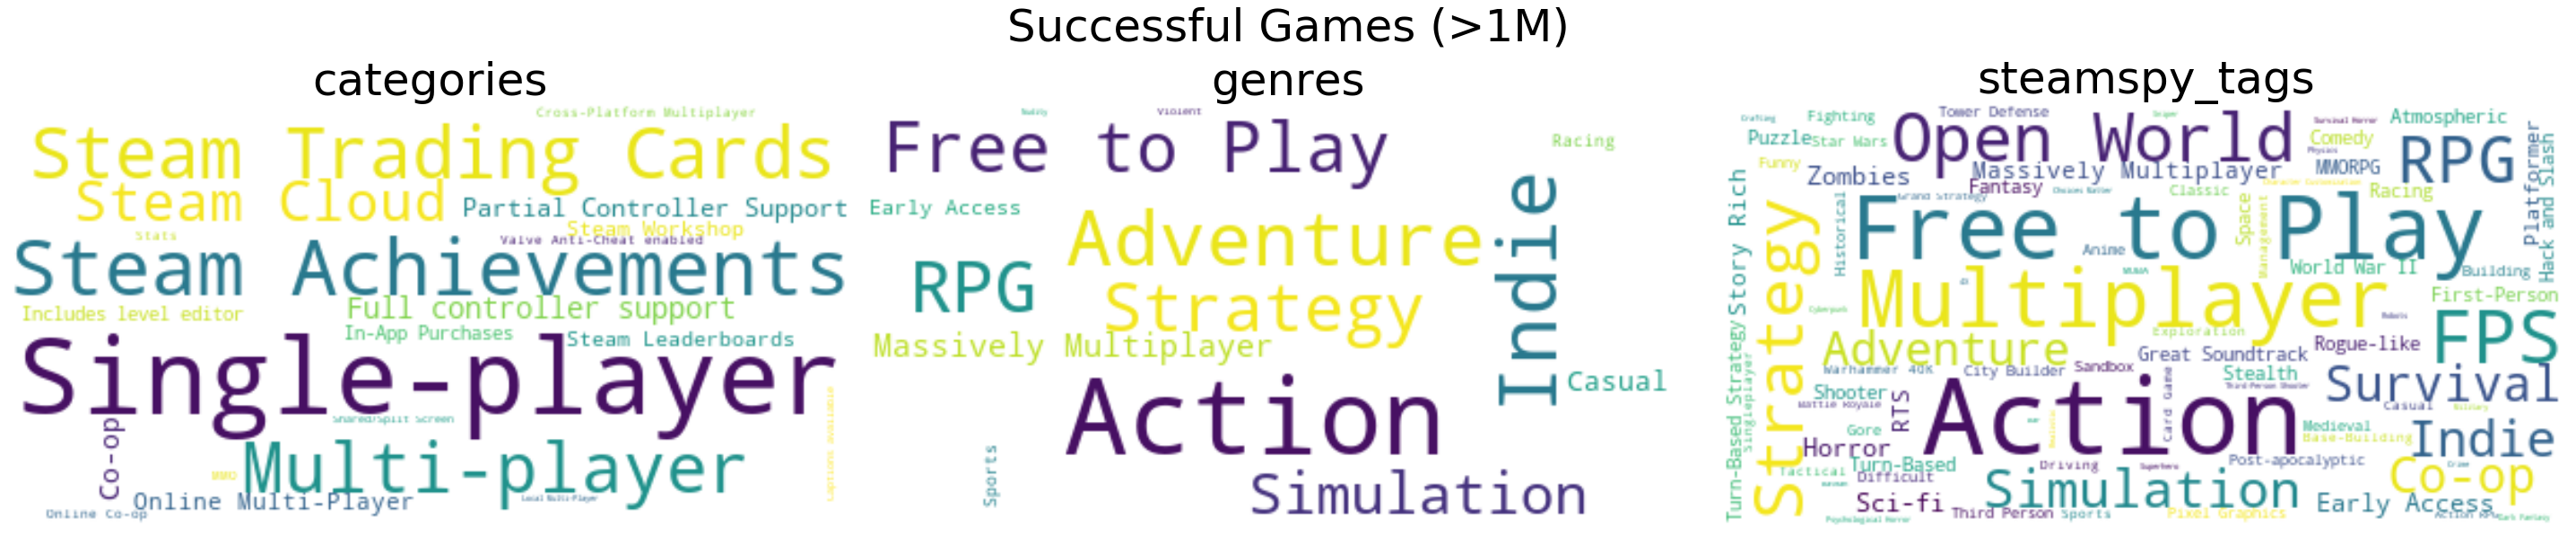

In [22]:
#### For total games ####
fig = plt.figure(figsize=[40,10])
fig.suptitle("Total Games", fontsize=50)
list_vcab = [cat_vocab, genres_vocab, steamspy_vocab]
titles = ["categories", "genres", "steamspy_tags"]
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    wc = wordcloud.WordCloud(background_color="white", max_font_size=50, random_state=0).generate_from_frequencies(list_vcab[i-1])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    ax.set_title(titles[i-1], size=50)
plt.tight_layout()
plt.show();
#### For successful games (owners > 1M ) ####
df_prepare_success = df_prepare[df_prepare["owners_median"] >= 1500000]
success_cat_vocab = {key:sum(df_prepare_success[key + "_x"]) if key in steamspy_vocab.keys() else sum(df_prepare_success[key]) for key in cat_vocab}
success_genres_vocab = {key:sum(df_prepare_success[key + "_x"]) if key in steamspy_vocab.keys() else sum(df_prepare_success[key]) for key in genres_vocab}
success_steamspy_vocab = {key:sum(df_prepare_success[key + "_y"]) if (key in cat_vocab.keys()) or (key in genres_vocab.keys()) else sum(df_prepare_success[key]) for key in steamspy_vocab}
fig = plt.figure(figsize=[40,10])
fig.suptitle("Successful Games (>1M)", fontsize=50)
list_vcab = [success_cat_vocab, success_genres_vocab, success_steamspy_vocab]
titles = ["categories", "genres", "steamspy_tags"]
for i in range(1,4):
    ax = fig.add_subplot(1,3,i)
    wc = wordcloud.WordCloud(background_color="white", max_font_size=50, random_state=0).generate_from_frequencies(list_vcab[i-1])
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    ax.set_title(titles[i-1], size=50)
plt.tight_layout()
plt.show();

Here, I used owner number > 1M to determine whether a game is successful. <br>
As shown above, there is no significant change in game categories. The only slight difference is that successful games has lager portion in *multi-player*, which makes sense since *multi-player* games require more players and might have more owners. <br>
Genre types and Steamspy_tags are similar, but Stemspy_tag have much detailed categories and voted by community. <br>Compared with total games, the percentages of *Indie, Casual, Adventure, Simulation,* and *Early Access* for successful games have dropped. It seems that if a game with these tags can be more dangerous and will be more unlikely successful compared a game with *Action* tag.

### <a id="Numerical"></a> 4) Numerical features: correlation

Check the correlation between numerical features and owners number. Here, we converted rating number to percentage. In addition, we also split release date features into year, month, and day.

In [23]:
df_prepare["positive_ratings_percentage"] = df_prepare["positive_ratings"]/( df_prepare["positive_ratings"]+ df_prepare["negative_ratings"])
df_prepare["negative_ratings_percentage"] = df_prepare["negative_ratings"]/( df_prepare["positive_ratings"]+ df_prepare["negative_ratings"])


In [24]:
def splitTime(ref_date):
    '''
    Split release date into year, month, and day
    '''
    ref_year, ref_month, ref_day = time.strptime(ref_date,'%Y-%m-%d').tm_year, time.strptime(ref_date,'%Y-%m-%d').tm_mon, time.strptime(ref_date,'%Y-%m-%d').tm_mday

    return ref_year, ref_month, ref_day

In [25]:
year = []
month = []
day = []
for i in range(df_prepare.shape[0]):
    y,m,d = splitTime(df_prepare.loc[i,"release_date"])
    year.append(y)
    month.append(m)
    day.append(d)
df_prepare["year"] = year
df_prepare["month"] = month
df_prepare["day"] = day

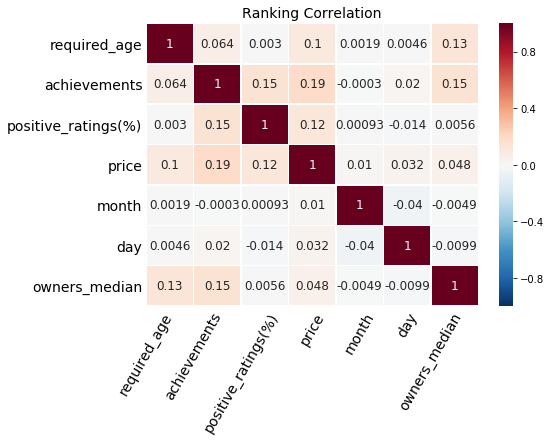

In [26]:
### Final correlation graph, should use data after adding release date information 
figure = plt.figure(figsize=[8,6])
ax = plt.gca()
seaborn.heatmap(df_prepare[["required_age", "achievements", "positive_ratings_percentage", "price", "month", "day", "owners_median"]].corr(method="spearman"), cmap="RdBu_r", annot=True, annot_kws={"size": 12}, vmin=-1, linewidths=0.5)
plt.xticks([0,1,2,3.5,4.5,5.5,6],["required_age", "achievements", "positive_ratings(%)", "price", "month", "day", "owners_median"], size=14, rotation="60")
plt.yticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["required_age", "achievements", "positive_ratings(%)", "price", "month", "day", "owners_median"], size=14)
ax.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.title("Ranking Correlation", size=14);
#plt.savefig("correlation.png", dpi=300);

The highest correlation is achieved by achievements, which is 0.15. Thus, no feature shows good correlation with owners_median, which indicates the challenge of this project.

### <a id="NewFeature"></a>5) New features: Developer_famous & Publisher_famous

For the developer and publisher, since there are two many different categorials, we converted them into two new features: **famous** and **non-famous**, based on their previous owners before target game released. These two features indicate the developer/publisher reputation effect on game owner numbers <br>
If a developer has average owners higher than **75%** of developers before the target game release date, we assume it's a famous developer. <br>
If a publisher has average owners higher than **75%** of publishers before the target game release date, we assume it's a famous publisher. <br>

In [27]:
def time_filter(data, ref_date):
    '''
    Remove games released after ref_date
    '''
    ref_year, ref_month, ref_day = time.strptime(ref_date,'%Y-%m-%d').tm_year, time.strptime(ref_date,'%Y-%m-%d').tm_mon, time.strptime(ref_date,'%Y-%m-%d').tm_mday
    data.release_date = data["release_date"].astype("datetime64")
    df_tmp = data[(data["release_date"].dt.year < ref_year) |
                  ((data["release_date"].dt.year == ref_year) & (data["release_date"].dt.month < ref_month)) | 
                  ((data["release_date"].dt.year == ref_year) & (data["release_date"].dt.month == ref_month) & (data["release_date"].dt.day < ref_day))
                 ]
    return df_tmp

In [28]:
def checkFamous(data, variable, ref_idx):
    '''
    Check the publisher/developer of certain game is famous or not (based on ref_idx) before game release.
    The assumption here, is the owners of certain games always increase significantly in a short time after game relaese.
    Based on this assumption, we can determine whether a company is famous or not using this simple function.
    However, this assumption might be not True.
    We can also use other information, such as metacritic score to determine whether a company is famous or not.
    
    variable: publisher or developer
    ref_idx: target game
    '''
    df_tmp = data[data.index != ref_idx]
    ref_date = data.iloc[ref_idx]["release_date"]
    ref_variable = data.iloc[ref_idx][variable]
    df_tmp = time_filter(df_tmp,ref_date)
    df_tmp_group = df_tmp.groupby(variable).agg({"owners_median": np.mean})
    df_tmp_group.reset_index(inplace=True)
    value = df_tmp.describe().loc["75%"].values[0]
    if df_tmp_group[df_tmp_group[variable] == ref_variable]["owners_median"].values >= value:
        return True
    else:
        return False

In [29]:
def addFamous(data, variable):
    '''
    Get famous data and add them into initial data
    variable: publisher or developer
    '''
    out = open("../data/famous_" + variable + ".csv", "w")
    famous_list = []
    for i in range(data.shape[0]):
        famous = checkFamous(data, variable, i)
        if famous:
            famous_list.append(1)
        else:
            famous_list.append(0)
        print(str(i) + "," + str(famous))
        out.write(str(famous) + "\n")
    out.close()
    #data[variable + "_famous"] = famous_list
    
    famous_percentage = len([i for i in famous_list if i == 1]) / len(famous_list)
    print("Famous percentage is " + str(famous_percentage))
    return data

In [ ]:
pd.options.mode.chained_assignment = None
df_prepare = addFamous(df_prepare, "developer")

In [ ]:
df_prepare = addFamous(df_prepare, "publisher")

In [30]:
df_famous_developer = pd.read_csv("../data/famous_developer.csv", header=None)
developer_famous = [1 if i == True else 0 for i in df_famous_developer[0].tolist()]
df_famous_publisher = pd.read_csv("../data/famous_publisher.csv", header=None)
publisher_famous = [1 if i == True else 0 for i in df_famous_publisher[0].tolist()]

In [31]:
df_prepare["developer_famous"] = developer_famous
df_prepare["publisher_famous"] = publisher_famous

*****************************************************************

## *2. Build Model*

### <a id="PrepareData"></a> 1) Prepare Dataset

Since there are too less games with owners larger than 10 million, we combined the games with owners lager than 10 million and use the average number to replace the initial owners_media.

In [32]:
df_use = df_prepare.copy()

In [33]:
for idx in df_use.loc[df_use["owners"].isin(["100000000-200000000", "50000000-100000000", "20000000-50000000", "10000000-20000000"])].index:
    df_use.iloc[idx, 18] = 26666667

26666667 is the average of owners_median of these games

In [34]:
#### Change number into classes ####
Y = df_use[["owners_median"]]
ec = LabelEncoder()
df_use["target"] = ec.fit_transform(Y)

In [35]:
#### Split dataset using 8:1:1 ####
train_idx, test_idx = train_test_split(df_use["appid"].values,  test_size=0.10, stratify=df_use["target"], random_state=0)
train_idx, val_idx = train_test_split(train_idx,  test_size=0.11, stratify=df_use[df_use["appid"].isin(train_idx)]["target"], random_state=0)


In [36]:
train_idx.shape
test_idx.shape
val_idx.shape

(21686,)

(2708,)

(2681,)

We first trained a **baseline model** with all features(no time features) and simple XGB classifer, and found there are some features with 0 feature importance. To accelerate the model training process, we **retrained the model without these features**, and includes time features(month and day). We also added class weight for each class.

In [37]:
#### Remove non-important features ####
features = ['english','required_age','achievements', 'price', 
            'positive_ratings_percentage', 'windows', 'mac', 'linux', 'developer_famous', 'publisher_famous'] + \
            list([key if key not in steamspy_vocab.keys() else key + "_x" for key in cat_vocab.keys()]) + \
            list([key if key not in steamspy_vocab.keys() else key + "_x" for key in genres_vocab.keys()]) + \
            list([key + "_y" if (key in cat_vocab.keys()) or (key in genres_vocab.keys()) else key for key in steamspy_vocab.keys()]) 

features_imp = pd.read_csv("../models/Base_line/feature_imp.csv", header = None, index_col=0)
features_imp.columns = features
mean_features_imp = features_imp.describe()[1:2].transpose()
mean_features_imp.sort_values("mean", inplace = True)
features_remove = [i for i in features if i not in mean_features_imp[mean_features_imp["mean"] == 0].index.tolist()]
features_remove = features_remove + ["month", "day"]
print(str(len(features_remove)) + " features")

217 features


In [38]:
X_train = df_use[df_use["appid"].isin(train_idx)][features_remove].values
Y_train = df_use[df_use["appid"].isin(train_idx)]["target"].values
#### sample weight is based on its target class
Y_train_weight = (Y_train + 1)/np.max(Y_train + 1)
X_val = df_use[df_use["appid"].isin(val_idx)][features_remove].values
Y_val = df_use[df_use["appid"].isin(val_idx)]["target"].values
Y_val_weight = (Y_val + 1)/np.max(Y_val + 1)
X_test = df_use[df_use["appid"].isin(test_idx)][features_remove].values
Y_test = df_use[df_use["appid"].isin(test_idx)]["target"].values

### <a id="TrainModel"></a>2) Train Model

We use **hold-out validation set** to do the early stopping. We also applied ensemble model to do the prediction.

In [39]:
trnp_df = pd.DataFrame({"index":[i for i in range(X_train.shape[0])]})
tesp_df = pd.DataFrame({"index":[i for i in range(X_test.shape[0])]})
valp_df = pd.DataFrame({"index":[i for i in range(X_val.shape[0])]})
out = open("../models/Final/feature_imp.csv", "w")
for i in range(10):
    if "pima.pickle_" + str(i) + ".dat" in os.listdir("../models/Final/"):
        xgb = pickle.load(open("../models/Final/pima.pickle_" + str(i) + ".dat", "rb"))
    else:
        xgb = XGBClassifier(n_estimators=1000, random_state=(i-1) * 10, colsample_bytree=0.8, learning_rate=0.2, objective="multi:softmax", num_class=10)
        xgb.fit(X_train, Y_train, sample_weight=Y_train_weight, eval_set=[(X_val, Y_val)], eval_metric="mlogloss", early_stopping_rounds=50, sample_weight_eval_set=[Y_val_weight])
        pickle.dump(xgb, open("../models/Final/pima.pickle_" + str(i) + ".dat", "wb"))
    f_importance = xgb.feature_importances_
    out.write(str(i) + "," + ",".join([str(f) for f in f_importance]) + '\n')
    trnp = xgb.predict(X_train, ntree_limit=xgb.best_ntree_limit)
    tesp = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
    valp = xgb.predict(X_val, ntree_limit=xgb.best_ntree_limit)
    if i == 1:
        trnp_df = pd.DataFrame({"data" + str(i):trnp})
        tesp_df = pd.DataFrame({"data" + str(i):tesp})
        valp_df = pd.DataFrame({"data" + str(i):valp})
    else:
        trnp_df["data" + str(i)] = trnp
        tesp_df["data" + str(i)] = tesp
        valp_df["data" + str(i)] = valp
out.close()


2632

2655

2655

2601

2601

2663

2652

2655

2637

2664

In [40]:
trnp_df_final = trnp_df.mode(axis = 1)[0]
tesp_df_final = tesp_df.mode(axis = 1)[0]
valp_df_final = valp_df.mode(axis = 1)[0]

*****************************************************************

## *3. Performance Analysis*

### <a id="CheckPerformance"></a>1) Check Performance

In [41]:
def getAccuracy(Y_true, Y_pred):
    '''
    Get prediction accuracy
    '''
    acc = (Y_pred == Y_true).sum().astype(float) / len(Y_true)*100
    return str(round(acc,2)) + "%"

def calTPR(predict, target, threshold):
    '''
    Calculate true positive rate
    '''
    tesFP_class = (lambda x: [1 if i >= threshold else 0 for i in x])(predict)
    tesFY_class = (lambda x: [1 if i >= threshold else 0 for i in x])(target)
    TP = [ idx for idx, i in enumerate(tesFY_class) if (i == 1) and (tesFP_class[idx] == 1) ]
    TotalP = [ idx for idx, i in enumerate(tesFY_class) if i == 1]
    TPR = len(TP) / len(TotalP)
    return TPR

def calFPR(predict, target, threshold):
    '''
    Calculate false positive rate
    '''
    tesFP_class = (lambda x: [1 if i >= threshold else 0 for i in x])(predict)
    tesFY_class = (lambda x: [1 if i >= threshold else 0 for i in x])(target)
    FP = [ idx for idx, i in enumerate(tesFY_class) if (i == 0) and (tesFP_class[idx] == 1) ]
    TotalN = [ idx for idx, i in enumerate(tesFY_class) if i == 0]
    FPR = len(FP) / len(TotalN)
    return FPR

In [42]:
### Accuracy
acc_train = getAccuracy(Y_train, trnp_df_final)
acc_val = getAccuracy(Y_val, valp_df_final)
acc_test = getAccuracy(Y_test, tesp_df_final)
print("Prediction accuracy:\nTrain:{},Validation:{},Test:{}".format(acc_train , acc_val, acc_test ))

Prediction accuracy:
Train:80.51%,Validation:69.56%,Test:68.5%


In [43]:
### TPR and FPR
results_train = calTPR(trnp_df_final, Y_train, 1), calFPR(trnp_df_final, Y_train, 1)
results_val = calTPR(valp_df_final, Y_val, 1), calFPR(valp_df_final, Y_val, 1)
results_test = calTPR(tesp_df_final, Y_test, 1), calFPR(tesp_df_final, Y_test, 1)
print("TPR:\nTrain:{:.2f},Validation:{:.2f},Test:{:.2f}".format(results_train[0], results_val[0], results_test[0]))
print("FPR:\nTrain:{:.2f},Validation:{:.2f},Test:{:.2f}".format(results_train[1], results_val[1], results_test[1]))


TPR:
Train:0.75,Validation:0.70,Test:0.69
FPR:
Train:0.08,Validation:0.08,Test:0.10


In [44]:
### F1 score 
f1_train = f1_score(Y_train, trnp_df_final, average="weighted")
f1_val= f1_score(Y_val, valp_df_final, average="weighted")
f1_test= f1_score(Y_test, tesp_df_final, average="weighted")
print("F1 score:\nTrain:{:.2f},Validation:{:.2f},Test:{:.2f}".format(f1_train, f1_val, f1_test ))

F1 score:
Train:0.80,Validation:0.68,Test:0.67


Compared with the highest ranking correlations got by single numerical features (0.15), our model still can achieve **much better performance** in owner prediction (around 70% accuracy, 0.7 TPR, and 0.7 F1 score)

### <a id="ErrorAnalysis"></a>2) Error Analysis

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None,cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=[8,6])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes)
    ax.set_ylabel(ylabel='True label', fontsize=14)
    ax.set_xlabel(xlabel='Predicted label', fontsize=14)
    ax.set_title(label=title, fontsize=14)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=12);

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),ha="center", va="center", size=12, color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout(pad=0.0001);
    
    return ax

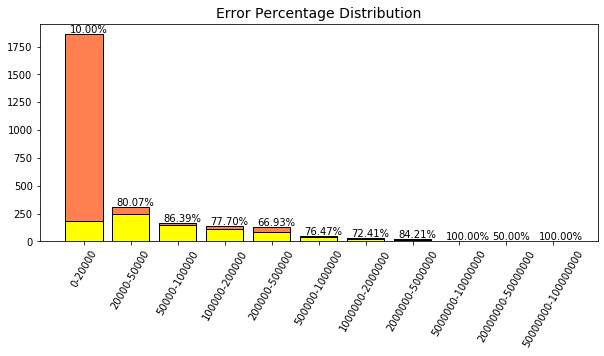

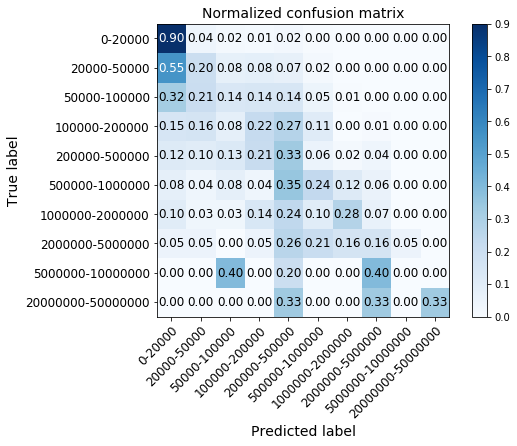

In [46]:
### Plot Error Percentage Distribution
df_test = df_use[df_use["appid"].isin(test_idx)]
### Initial target class distribution ###
df_test_owner_infor = { df_tmp[0]: len(df_tmp[1]) for df_tmp in df_test.groupby("owners")}
df_test_owner_infor = { x:y for x,y in sorted(df_test_owner_infor.items(), key = lambda x: getMedian(x[0]))}
df_test["predict"] = tesp_df_final.values
df_test_error = df_test[df_test["predict"] != df_test["target"]]
df_test_error_owner_infor = { df_tmp[0]: len(df_tmp[1]) for df_tmp in df_test_error.groupby("owners")}
df_test_error_owner_infor = { x:y for x,y in sorted(df_test_error_owner_infor.items(), key = lambda x: getMedian(x[0]))}
fig = plt.figure(figsize=[10,4])
ax = plt.gca()
plt.bar(df_test_owner_infor.keys(), df_test_owner_infor.values(), edgecolor="black", color="coral")
plt.bar(df_test_error_owner_infor.keys(), df_test_error_owner_infor.values(), edgecolor="black", color="yellow")

for idx, key in enumerate(df_test_owner_infor.keys()):
    ax.annotate("{:.2f}%".format(float(df_test_error_owner_infor[key]/df_test_owner_infor[key] * 100)), (idx-0.3, df_test_owner_infor[key] + 10), fontsize=10)
plt.xticks(rotation="60", fontsize=10)
plt.title("Error Percentage Distribution", size=14);
#plt.xlabel("The number of owners (test set)", size=16)
#plt.ylabel("Frequency", size=16);
### Plot normalized confusion matrix ###
plot_confusion_matrix(Y_test, tesp_df_final, classes=np.array([i for i in df_test_owner_infor.keys()]), normalize=True, title='Normalized confusion matrix');
#plt.savefig("Normalized_confusion_matrix.jpg", dpi=300);

To further analyze the error in our test set, the normalized confusion matrix and error percentage distribution have also been measured, and they both shows similar results, which indicates our model can't achieve good performance for games with **higher than 20k owners** ( with no larger than 40% accuracy).

### <a id="FeatureImp"></a> 3) Feature Importance

In [47]:
features_imp = pd.read_csv("../models/Final/feature_imp.csv", header = None, index_col=0)
features_imp.columns = features_remove
mean_features_imp = features_imp.describe()[1:2].transpose()
mean_features_imp.sort_values("mean", inplace = True)

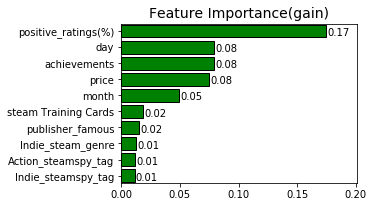

In [48]:
fig = plt.figure(figsize=[6,3])
ax = plt.gca()
plt.barh(mean_features_imp.index[-10:], mean_features_imp["mean"][-10:], color="green", edgecolor="black")
for idx, x in enumerate(mean_features_imp["mean"][-10:]):
    ax.annotate("{:.2f}".format(x), (x + 0.001, idx-0.3))
plt.tight_layout(pad=2.0)
plt.yticks([9,8,7,6,5,4,3,2,1,0], ["positive_ratings(%)", "day", "achievements", "price", "month", "steam Training Cards", "publisher_famous", "Indie_steam_genre", "Action_steamspy_tag", "Indie_steamspy_tag"])
plt.margins(x=0.15, y = 0.005)
#plt.xlabel("Feature Importance (gain)")
plt.title("Feature Importance(gain)", size=14);
#plt.savefig("Feature_importance.png", dpi=300);

The percentage of positive ratings has highest importance, which indicate the big effect of positive reviews. One thing should be noted is the *percentage of positive ratings* is got after game release here, but it can also be got through certain pre-testing or inner-testing from small group of reviewers before final release.<br>
Below percentage of *positive ratings, release day, number of achievements, price,* and *release month* are also very important. It's quit surprise to find that release date matters in game success. In addition, the *categories features* and *publisher reputation* also have relative important effect on model prediction. 

*****************************************************************

## *Summary*

A machine learning model based on **XGBoost** has been developed for **predicting Steam game owner number**, and it can achieve around **70% accuracy** in validation and test set. Compared with the highest ranking correlations reached by single numerical features (0.15), our model still has much improved performance. <br>
Our analysis also indicates that some important factor should be considered during game development:<br>
If you want to build a successful game, you should **think about game genre**(try to develop action game), **set a reasonable game price** (free to play if you can),  **find a famous publisher**, and try to **achieve good positive ratings percentage** from inner-testing before the final release. Finally, don't forget to **choose a lucky release date** for your game !

*****************************************************************

## *Future Work*

There is still much improvement space of our current model. Actually, the success of a game is most determined by its quality, include the animation, user experience, graphic design,  story design, etc.  However, I haven't include any these features in current analysis, and only considered the outer effect on the game. In future work, I will try to get more features related to the quality.